In [230]:

import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
import time
import math


import torch as T
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from collections import deque, namedtuple

# from keras.models import Sequential
# from keras.layers import *
# from keras.optimizers import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import rc, animation
from IPython import display
from IPython.display import HTML
%matplotlib inline


In [231]:
class DQNmodel(nn.Module):
    def __init__(self,state_size,action_size,lr):
        super(DQNmodel, self).__init__()
        self.linear1 = nn.Linear(state_size,256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, action_size)
        
        self.optimizer = optim.Adam(self.parameters(), lr)
        self.loss = nn.MSELoss()
        
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        state = T.Tensor(state).to(self.device)
        out = self.linear1(state)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out

In [236]:
class replay_buffer:
    def __init__(self,mem_size,state_size,action_size,mem_cntr):
        self.mem_size = mem_size
        self.state_memory = np.zeros((self.mem_size, *[state_size]))
        self.new_state_memory = np.zeros((self.mem_size, *[state_size]))
        self.action_memory = np.zeros((self.mem_size,action_size),
                                      dtype=np.uint8)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)
        self.mem_cntr = mem_cntr
        self.action_size = action_size
        
    def storeTransition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        actions = np.zeros(self.action_size)
        actions[action] = 1.0
        self.action_memory[index] = actions
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = 1 - terminal
        self.mem_cntr += 1
        self.action_space = [0,1]
        
    def get_sample(self,batch_size):
        max_mem = self.mem_cntr if self.mem_cntr < self.mem_size \
                                    else self.mem_size

        batch = np.random.choice(max_mem, batch_size)
        state_batch = self.state_memory[batch]
        action_batch = self.action_memory[batch]
        
        action_values = np.array(self.action_space, dtype=np.int32)
        action_indices = np.dot(action_batch, action_values)
        reward_batch = self.reward_memory[batch]
        new_state_batch = self.new_state_memory[batch]
        terminal_batch = self.terminal_memory[batch]
        return state_batch,action_batch, action_values,action_indices, reward_batch,new_state_batch,terminal_batch

In [1]:
class DQNAgent(object):
    def __init__(self,state_size,action_size,lr,epsilon,batch_size,max_mem,mem_cntr):
        self.gamma = 0.99
        self.lr = lr
        self.epsilon = epsilon
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.model = DQNmodel(state_size,action_size,self.lr)
        self.target_model = DQNmodel(state_size,action_size,self.lr)
        self.memory = replay_buffer(max_mem,state_size,action_size,mem_cntr)
        self.EPS_MIN = 0.01
        self.EPS_DEC = 0.99
        self.tau = 0.1
        self.count = 0
        
    def get_action(self, observation):
        rand = np.random.random()
        actions = self.model.forward(observation)
        if rand > self.epsilon:
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_size)
        return action
    
    def learn(self):
        self.model.optimizer.zero_grad()

        state_batch,action_batch, action_values,action_indices, reward_batch,new_state_batch,terminal_batch = self.memory.get_sample(self.batch_size)
       
        states = T.FloatTensor(state_batch).to(self.model.device)
        actions = T.LongTensor(action_batch).to(self.model.device)
        rewards = T.FloatTensor(reward_batch).to(self.model.device)
        next_states = T.FloatTensor(new_state_batch).to(self.model.device)
        dones = T.FloatTensor(terminal_batch).to(self.model.device)
        
        self.model.eval()
        self.target_model.eval()
        
        action_new = self.model.forward(next_states).max(dim=1)[1].cpu().data.view(-1, 1)
        action_new_onehot = T.zeros(self.batch_size, self.action_size)
        action_new_onehot = Variable(action_new_onehot.scatter_(1, action_new, 1.0)).to(self.model.device)
        
        y = (reward + torch.mul(((self.target_model.forward(next_states)*action_new_onehot).sum(dim=1)*dones),self.gamma))
        
        self.model.train()
        Q = (self.model.forward(states)*actions).sum(dim=1)
        loss = self.model.loss(input=Q, target=y.detach())
        
        # backward optimize
        self.model.optimizer.zero_grad()
        loss.backward()
        self.model.optimizer.step()
        
#         action_values = self.model.forward(states)
#         # compute loss
#         curr_Q = self.model.forward(states).detach()
#         next_Q = self.model.forward(next_states).detach()
#         best_action = np.argmax(next_Q[0].numpy())
        
#         target_Q = self.target_model.forward(next_states).detach()
#         best_next_q = target_Q[0][best_action].numpy()
#         update_q = reward + self.gamma*best_next_q 
#         curr_Q[0][actions] = update_q

#         loss = F.mse_loss(action_values,curr_Q).to(self.model.device)
#         loss.backward()
#         self.model.optimizer.step()
        
        if self.count == 100:
            for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
                target_param.data.copy_(self.tau * param + (1 - self.tau) * target_param)
            self.count = 0
        self.count += 1
    def update_epsilon(self,number_of_episodes):
        self.epsilon = self.epsilon*(1-1/number_of_episodes)
        return self.epsilon
    
    

In [238]:
env = gym.make("CartPole-v1")
env.reset()
# plt.imshow(env.render('rgb_array'))

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [224]:
env = gym.make('LunarLander-v2')
env.reset()
# plt.imshow(env.render('rgb_array'))
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [ ]:
lr = 0.001
epsilon = 1
batch_size = 64
max_mem = 10000
mem_cntr = 0
count = 0
num_episodes = 5000
episode_rewards = []

agent = DQNAgent(state_size,action_size,lr,epsilon,batch_size,max_mem,mem_cntr)

for episode in range(num_episodes):
    done = False
    state = env.reset()
    total_reward = 0
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action) 
        agent.memory.storeTransition(state, action, reward,next_state,done)
        state = next_state
        total_reward += reward

        if count > batch_size:
            agent.learn()
            agent.update_epsilon(num_episodes)
        count = count + 1
        
        if done: 
            break
    
    episode_rewards.append(total_reward)
    
    if episode % 100 == 0:
        
        print('Episode {}'.format(episode))
        print('Last Episode Reward: {}'.format(total_reward))
        print('-'*10)

Episode 0
Last Episode Reward: 14.0
----------
Episode 100
Last Episode Reward: 79.0
----------
Episode 200
Last Episode Reward: 129.0
----------
Episode 300
Last Episode Reward: 151.0
----------


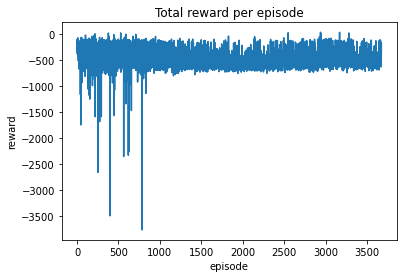

In [228]:
plt.plot(episode_rewards)
plt.title("Total reward per episode")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

In [229]:
np.save('doubledqn_LunarLander',episode_rewards)